<a href="https://colab.research.google.com/github/ZitongZhou/react_inverse/blob/master/inputs_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pickle as pk
import os
import time
from google.colab import drive
from google.colab import files
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [65]:
def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        axs.set_xlim(0,Lx)
        axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
        name = title + '.pdf'
        plt.title(title)
    #         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
        plt.show()
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(10, 6))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            c01map = ax.imshow(c_map[i], cmap='jet',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            fig.colorbar(c01map, ax=ax, shrink=0.5)
        plt.suptitle(title)
        name = title + '.pdf'
        plt.tight_layout()
    #         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
        plt.show()
    return

## Read input and output files, pickle as dataset

In [39]:
## make autoregressive dataset: conc[t] + S[t] + kd ----> conc[t+1] + head, 
## skip the file that does not have the corresponding output file, or the output
## concentration length is not 10.
AR_input = []
AR_output = []
problematic_conc = []
dir = os.listdir('/content/drive/MyDrive/react_inverse/simu_outputs/')
for ndata in tqdm(range(len(dir)), unit="files"):
    ## input: kd(6, 41, 81), welspd(5,[5]), [5]: loc+conc+type 
    input_file =  h5py.File('/content/drive/MyDrive/react_inverse/simu_inputs/input_{}.hdf5'.format(ndata), 'r')
    kd = np.array(input_file['kd'])
    welspd = np.array(input_file['welspd'])
    input_file.close()
    ## output: conc(10, 6, 41, 81), head(6, 41, 81)
    try:
        f = h5py.File('/content/drive/MyDrive/react_inverse/simu_outputs/output_{}.hdf5'.format(ndata), "r")
    except:
        continue
    conc = np.array(f['concentration'])
    conc[conc<0] = 0
    head = np.array(f['head'])
    f.close()
    ## S: release for 5 steps
    if len(conc) != 10:
        problematic_conc.append(ndata)
    else:
        np.concatenate((np.zeros((1, 6, 41, 81)), conc), axis=0)
        S = np.zeros((len(conc)-1, 41, 81))
        for i in range(len(welspd)-1):
            S[i, int(welspd[i,1]), int(welspd[i,2])] = welspd[i,3]
        for i in range(len(conc)-1):
            AR_input.append([conc[i], kd, S[i]])
            AR_output.append([conc[i+1], head])

print(len(AR_input))
print(len(AR_input[0]))

100%|██████████| 4999/4999 [01:52<00:00, 44.60files/s]

44928
3


In [69]:
with open('/content/drive/MyDrive/react_inverse/training_data/AR_dataset.pkl', 'wb') as file:
    pk.dump([AR_input, AR_output], file)

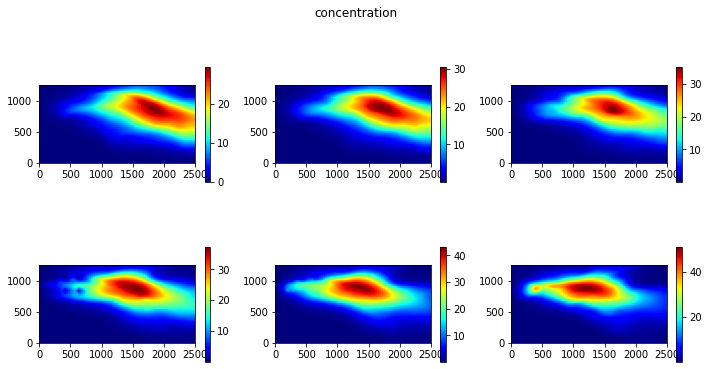

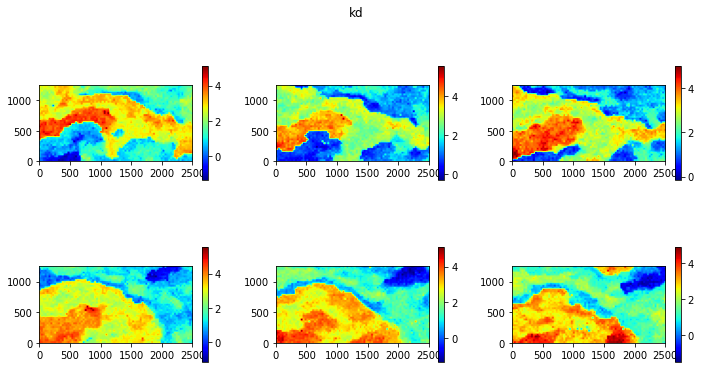

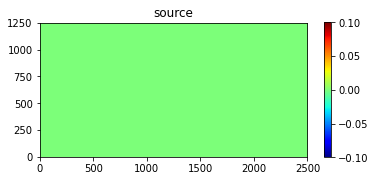

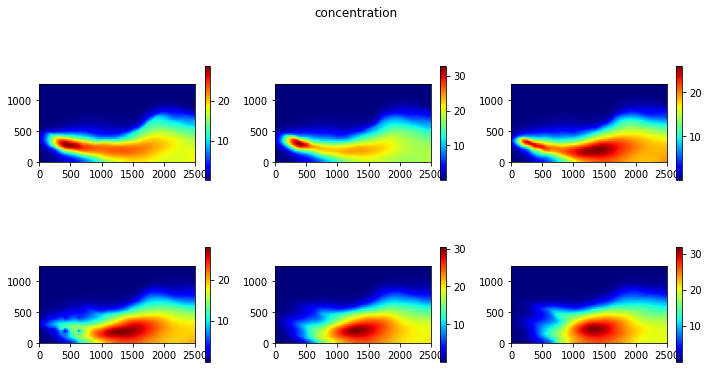

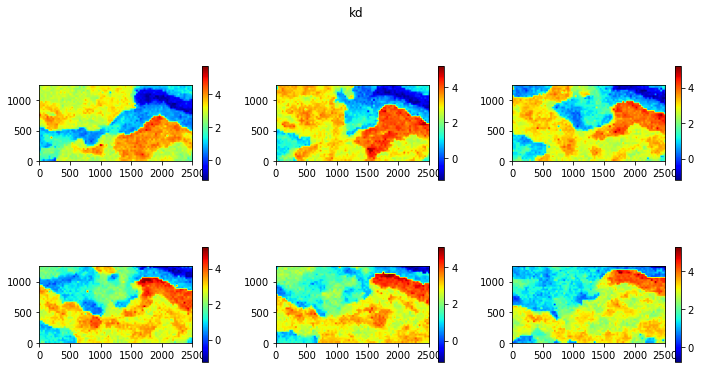

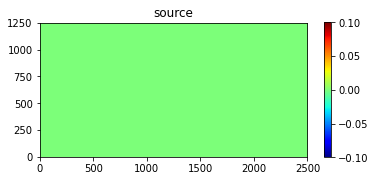

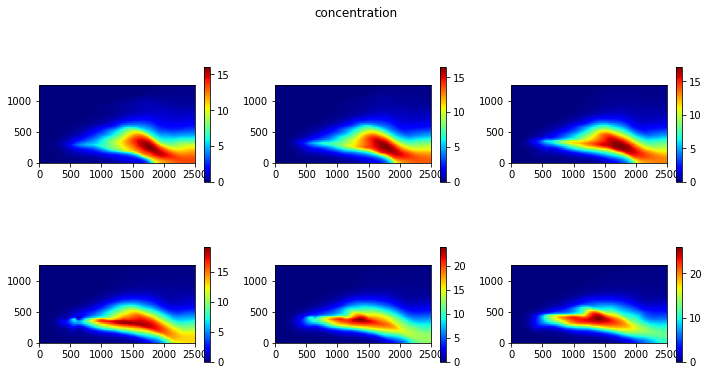

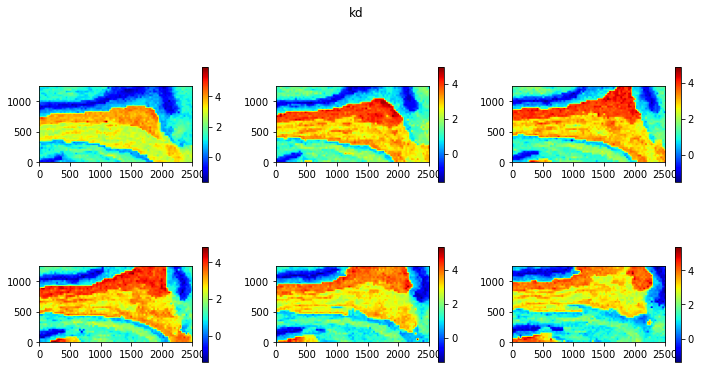

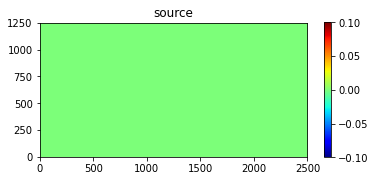

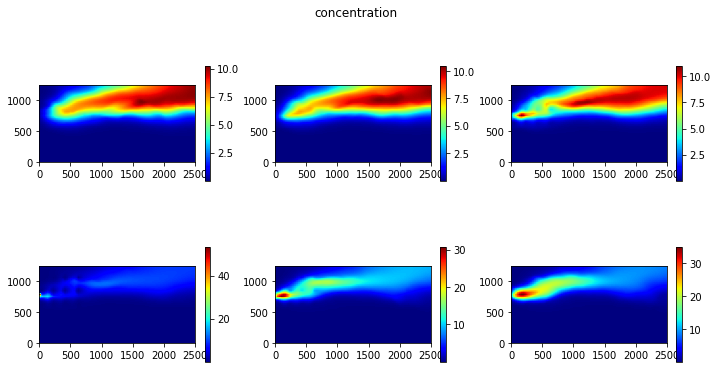

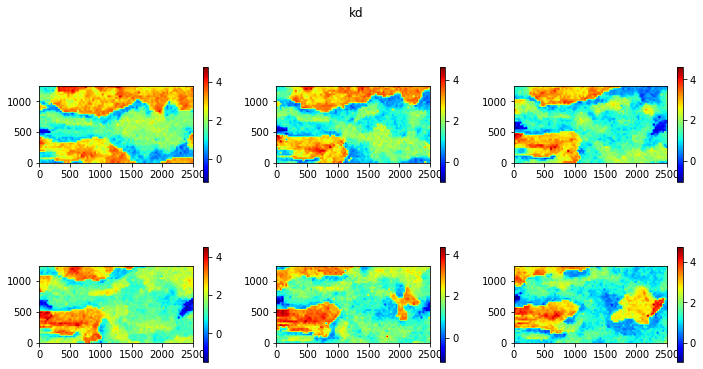

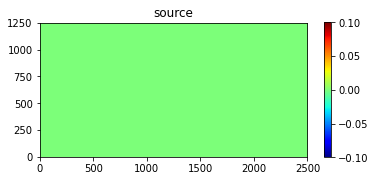

In [67]:
np.random.seed(88)
ind = np.random.randint(0, len(AR_input), 4)
for i in ind:
    input = AR_input[i].copy()
    output = AR_output[i].copy()
    simple_plot(input[0], 'concentration')
    simple_plot(input[1], 'kd')
    simple_plot(input[2], 'source')

In [ ]:
for i in range(1):
  output_file = '/content/drive/MyDrive/react_inverse/simu_outputs/output_'+str(i)+'.hdf5'
  f = h5py.File(output_file, "r")
  conc = np.array(f['concentration'])
  head = np.array(f['head'])
  simple_plot(conc[0][3], title='conc0')
  simple_plot(conc[1][3], title = 'conc1')
  simple_plot(conc[2][3], title = 'conc2')
  simple_plot(conc[3][3], title = 'conc3')
  simple_plot(conc[4][3], title = 'conc4')
  simple_plot(conc[5][3], title = 'conc5')
  f.close()

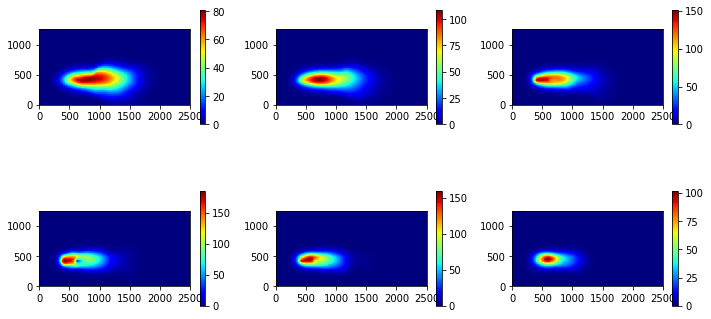

In [63]:
simple_plot(conc[5])

## Make input files

In [ ]:
assert len(kds[0])==6 and len(kds[0][0])==41 and len(kds[0][0][0])==81, \
    'size error, should be [6, 41, 81]'+str([len(kds[0]), len(kds[0][0]), len(kds[0][0][0])])

In [ ]:
with open('/content/drive/MyDrive/react_inverse/training_data/kds.pkl', 'rb') as file:
    kds = pk.load(file)

In [ ]:
N = 15000
# local_state = np.random.RandomState(seed = None)

### x
np.random.seed(888)
y_wel = np.array([6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34])# #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([1, 1, 1, 1, 1, 
         7, 7, 7, 7, 7,
         13, 13, 13, 13, 13,
         20, 20, 20, 20, 20])# #np.random.randint(low = 0, high = 25, size = 20)
wells = {i: [y_wel[i], x_wel[i]] for i in range(len(y_wel))}

x_ind = np.random.choice(20, N)

x = [wells[x_ind[i]] for i in range(N)]

### q
q = 100*np.random.randint(low=1, high=15, size=(N, 5))

### make well stress period data:
con_rate = []
for sim in range(N):
    welspd = []
    for i in range(5):
        welspd.append([3, x[sim][0], x[sim][1], q[sim, i], 2])
    welspd.append([3, x[sim][0], x[sim][1], 0, 2])
    con_rate.append(welspd)
con_rate = np.array(con_rate)

In [ ]:
con_rate[1996]

array([[   3,   27,   20, 1400,   -1],
       [   3,   27,   20,  400,   -1],
       [   3,   27,   20,  100,   -1],
       [   3,   27,   20,  200,   -1],
       [   3,   27,   20,  400,   -1],
       [   3,   27,   20,    0,   -1]])

In [ ]:
N = 5000
for ndata in range(N):
    hf =  h5py.File('/content/drive/MyDrive/react_inverse/simu_inputs/input_{}.hdf5'.format(ndata), 'w')
    hf.create_dataset('kd', data = kds[ndata], dtype ='f', compression = 'gzip')
    hf.create_dataset('welspd', data = con_rate[ndata], dtype ='f', compression = 'gzip')
    hf.close()